# Benchmarking

The goal of this notebook is to test the various tools we have defined to see which perform the best. Taking from the study by Santamaría, Mihaljević (2018), this can be defined by looking at which tools perform the best on a series of 4 metrics, as defined below : 
- *errorCoded*
- *errorCodedWithoutNa*
- *naCoded*
- *errorGenderBias*

On top of this, we add the *weighted error*, which allows a balance by valuing non-classification less strongly than misclassification via the use of a parameter $w$. 

On the same dataset, we also define the relative statistical value of including the origine within the test. We use the McNemar's test to define if the origine really helped the tools make more precise inference, or if it was just a fluke. 

## Getting the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
%cd ../..
from notebooks.helpers.evaluator import Evaluator, StatisticalTester, EvalManager
%load_ext autoreload
%autoreload 2

c:\Users\brief\Desktop\Master\Ecole\Semestre3\M8_ProjetDeRecherche\code_ProjetDeRecherche


C:\Users\brief\AppData\Roaming\Python\Python312\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
code_to_continent_table = pd.read_csv('C:/Users/brief/Desktop/Master/Ecole/Semestre3/M8_ProjetDeRecherche/code_ProjetDeRecherche/data/rawData/countryCodesToContinent/country-and-continent-codes-list.csv')
CountryToContinent = code_to_continent_table[['Two_Letter_Country_Code', 'Continent_Code']].fillna(
    'NA').drop_duplicates(
        subset='Two_Letter_Country_Code', keep='first').set_index('Two_Letter_Country_Code')['Continent_Code'].to_dict()


In [3]:
df_masterTest = pd.read_csv("C:/Users/brief/Desktop/Master/Ecole/Semestre3/M8_ProjetDeRecherche/code_ProjetDeRecherche/data/preprocessedTestData/masterTest.csv")

C:\Users\brief\AppData\Local\Temp\ipykernel_19476\3181202359.py:1: DtypeWarning: Columns (8,10,15,16,17,18,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_masterTest = pd.read_csv("C:/Users/brief/Desktop/Master/Ecole/Semestre3/M8_ProjetDeRecherche/code_ProjetDeRecherche/data/preprocessedTestData/masterTest.csv")


In [4]:
df_master_noUnknown = df_masterTest.loc[df_masterTest['index']!='unknown', :]
df_master_noUnknown['index'].value_counts(dropna=False)

index
8       12
12      12
17      12
18      12
20      12
        ..
8784     2
8785     2
8786     2
8791     2
9079     1
Name: count, Length: 14821, dtype: int64

In [5]:
check = df_master_noUnknown['index'].apply(int)
df_master_noUnknown['index'] = check
df_master_noUnknown.info()

<class 'pandas.core.frame.DataFrame'>
Index: 128684 entries, 0 to 128683
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   index                        128684 non-null  int64  
 1   fullName                     128684 non-null  object 
 2   namePassed                   128574 non-null  object 
 3   correctGender                128684 non-null  object 
 4   predictedGender              128684 non-null  object 
 5   localization                 127204 non-null  object 
 6   useLocalization              128684 non-null  bool   
 7   serviceUsed                  128684 non-null  object 
 8   extra_useFullName            25717 non-null   object 
 9   extraProbability             76597 non-null   float64
 10  extraIdentifiedFirstName     25114 non-null   object 
 11  extraIdentifiedLastName      0 non-null       float64
 12  isCorrect                    128684 non-null  bool   
 13  sour

In [6]:
df_master_noUnknown['useLocalization'].value_counts(dropna=False)

useLocalization
False    65095
True     63589
Name: count, dtype: int64

# Base metric and stat

In [7]:
manager = EvalManager()

## conf matrix without useLocal whole dataset

In [8]:
manager.getConfMatrix(df_master_noUnknown, False)

Conf matrix for genderAPI.io without useLocal
   f_pred  m_pred  u_pred
f    5882     465      52
m     294    6247      79
13019
------------
Conf matrix for genderize.IO without useLocal
   f_pred  m_pred  u_pred
f    5865     460      74
m     271    6266      83
13019
------------
Conf matrix for genderGuesser without useLocal
   f_pred  m_pred  u_pred
f    4609     186    1604
m     167    4864    1589
13019
------------
Conf matrix for NamSor without useLocal
   f_pred  m_pred  u_pred
f    5879     520       0
m     363    6257       0
13019
------------
Conf matrix for genderAPI.com without useLocal
   f_pred  m_pred  u_pred
f    5693     528     178
m     225    6203     192
13019
------------


## conf matrix with useLocal whole dataset

In [9]:
manager.getConfMatrix(df_master_noUnknown, True)

Conf matrix for genderAPI.io with useLocal
   f_pred  m_pred  u_pred
f    5773     505       2
m     231    6209       2
12722
------------
Conf matrix for genderize.IO with useLocal
   f_pred  m_pred  u_pred
f    5756     453      72
m     265    6099      78
12723
------------
Conf matrix for genderGuesser with useLocal
   f_pred  m_pred  u_pred
f    2434      62    3785
m      52    2584    3806
12723
------------
Conf matrix for NamSor with useLocal
   f_pred  m_pred  u_pred
f    5846     435       0
m     280    6162       0
12723
------------
Conf matrix for genderAPI.com with useLocal
   f_pred  m_pred  u_pred
f    5662     438     181
m     173    6056     188
12698
------------


In [10]:
df_master_noUnknown.columns

Index(['index', 'fullName', 'namePassed', 'correctGender', 'predictedGender',
       'localization', 'useLocalization', 'serviceUsed', 'extra_useFullName',
       'extraProbability', 'extraIdentifiedFirstName',
       'extraIdentifiedLastName', 'isCorrect', 'source', 'extraTotalName',
       'extraCountryUsedByService', 'extraUsedAI', 'extraForcedGenderize',
       'extraPreciseGenderPredicted', 'extraCount', 'extraGenderScale',
       'extraScore', 'extraProbabilityCalibrated', 'extraScript'],
      dtype='object')

## metric on whole dataset

In [11]:
stat_df_whole, metric_df_whole = manager.getMetricWholeDataset(df_master_noUnknown)

In [12]:
metric_df_whole.round(4)[['service_used', 'useLocal', 'error_with_unknown', 'error_without_unknown']]

,service_used,useLocal,error_with_unknown,error_without_unknown
0,NamSor,True,0.0562,0.0562
0,NamSor,False,0.0678,0.0678
0,genderAPI.com,True,0.0772,0.0496
0,genderAPI.com,False,0.0863,0.0595
0,genderAPI.io,True,0.0582,0.0579
0,genderAPI.io,False,0.0684,0.0589
0,genderGuesser,True,0.6056,0.0222
0,genderGuesser,False,0.2724,0.0359
0,genderize.IO,True,0.0682,0.0571
0,genderize.IO,False,0.0682,0.0568


In [13]:
metric_df_whole['diff'] = metric_df_whole['error_with_unknown'] - metric_df_whole['error_without_unknown']
metric_df_whole[metric_df_whole['useLocal']==True].sort_values('weighted_error').round(4)

,service_used,useLocal,error_with_unknown,error_without_unknown,error_unknown,error_gender_bias,weighted_error,diff
0,genderAPI.com,True,0.0772,0.0496,0.0291,-0.0215,0.0552,0.0276
0,NamSor,True,0.0562,0.0562,0.0000,-0.0122,0.0562,0.0000
0,genderAPI.io,True,0.0582,0.0579,0.0003,-0.0215,0.0579,0.0003
0,genderize.IO,True,0.0682,0.0571,0.0118,-0.0150,0.0594,0.0111
0,genderGuesser,True,0.6056,0.0222,0.5966,-0.0019,0.2454,0.5834


In [14]:
metric_df_whole[metric_df_whole['useLocal']==False].loc[:, metric_df_whole.columns!='useLocal'].sort_values('error_with_unknown').round(4)

,service_used,error_with_unknown,error_without_unknown,error_unknown,error_gender_bias,weighted_error,diff
0,NamSor,0.0678,0.0678,0.0000,-0.0121,0.0678,0.0000
0,genderize.IO,0.0682,0.0568,0.0121,-0.0147,0.0591,0.0114
0,genderAPI.io,0.0684,0.0589,0.0101,-0.0133,0.0608,0.0095
0,genderAPI.com,0.0863,0.0595,0.0284,-0.0240,0.0650,0.0267
0,genderGuesser,0.2724,0.0359,0.2453,-0.0019,0.0948,0.2364


In [15]:
stat_df_whole

,service_used,statistic,p_value,b,c,odds_ratio,cohen_g,ci_low,ci_high
0,NamSor,56.0,3.900842e-22,56,210,3.750000,0.578947,2.792617,5.035600
0,genderAPI.com,108.0,1.341608e-10,108,225,2.083333,0.351351,1.656200,2.620624
0,genderAPI.io,176.0,7.739351e-10,176,312,1.772727,0.278689,1.473660,2.132488
0,genderGuesser,1254.0,0.000000e+00,5506,1254,0.227752,-0.628994,0.214204,0.242156
0,genderize.IO,0.0,1.000000e+00,0,0,inf,NaN,NaN,NaN


In [16]:
stat_df_whole[['service_used','ci_low', 'ci_high']]

,service_used,ci_low,ci_high
0,NamSor,2.792617,5.035600
0,genderAPI.com,1.656200,2.620624
0,genderAPI.io,1.473660,2.132488
0,genderGuesser,0.214204,0.242156
0,genderize.IO,NaN,NaN


# Metric per country

In [17]:
df_metricPerCountry = manager.metricPerCountry(masterdf=df_master_noUnknown, threshhold=10)

c:\Users\brief\Desktop\Master\Ecole\Semestre3\M8_ProjetDeRecherche\code_ProjetDeRecherche\notebooks\helpers\evaluator.py:60: RuntimeWarning: invalid value encountered in scalar divide
  error_without_unknown = (conf_matrix.loc['f', 'm_pred'] + conf_matrix.loc['m', 'f_pred']) / \
c:\Users\brief\Desktop\Master\Ecole\Semestre3\M8_ProjetDeRecherche\code_ProjetDeRecherche\notebooks\helpers\evaluator.py:87: RuntimeWarning: invalid value encountered in scalar divide
  error_gender_bias = (conf_matrix.loc['m', 'f_pred'] - conf_matrix.loc['f', 'm_pred']) / \
c:\Users\brief\Desktop\Master\Ecole\Semestre3\M8_ProjetDeRecherche\code_ProjetDeRecherche\notebooks\helpers\evaluator.py:72: RuntimeWarning: invalid value encountered in scalar divide
  error_with_unknown = (true_f_and_m - true_pred_f_and_m) / true_f_and_m
c:\Users\brief\Desktop\Master\Ecole\Semestre3\M8_ProjetDeRecherche\code_ProjetDeRecherche\notebooks\helpers\evaluator.py:80: RuntimeWarning: invalid value encountered in scalar divide
  e

In [18]:
df_metricPerCountry['continent'] = df_metricPerCountry['country'].map(CountryToContinent)
df_metricPerCountry

,service_used,country,useLocal,population,error_with_unknown,error_without_unknown,error_unknown,error_gender_bias,weighted_error,continent
0,NamSor,BD,False,6.0,0.000000,0.000000,0.0,0.00000,0.000000,AS
0,NamSor,PY,False,32.0,0.031250,0.031250,0.0,0.03125,0.031250,SA
0,NamSor,FI,False,66.0,0.060606,0.060606,0.0,0.00000,0.060606,EU
0,NamSor,TM,False,6.0,0.000000,0.000000,0.0,0.00000,0.000000,AS
0,NamSor,YE,False,3.0,0.000000,0.000000,0.0,0.00000,0.000000,AS
...,...,...,...,...,...,...,...,...,...,...
0,genderize.IO,ZW,True,20.0,0.100000,0.100000,0.0,0.10000,0.100000,AF
0,genderize.IO,SA,True,7.0,0.000000,0.000000,0.0,0.00000,0.000000,AS
0,genderize.IO,KG,True,10.0,0.000000,0.000000,0.0,0.00000,0.000000,AS
0,genderize.IO,SV,True,6.0,0.000000,0.000000,0.0,0.00000,0.000000,NA


## Annexe 7 : 	Impact de l’origine sur les performances des outils

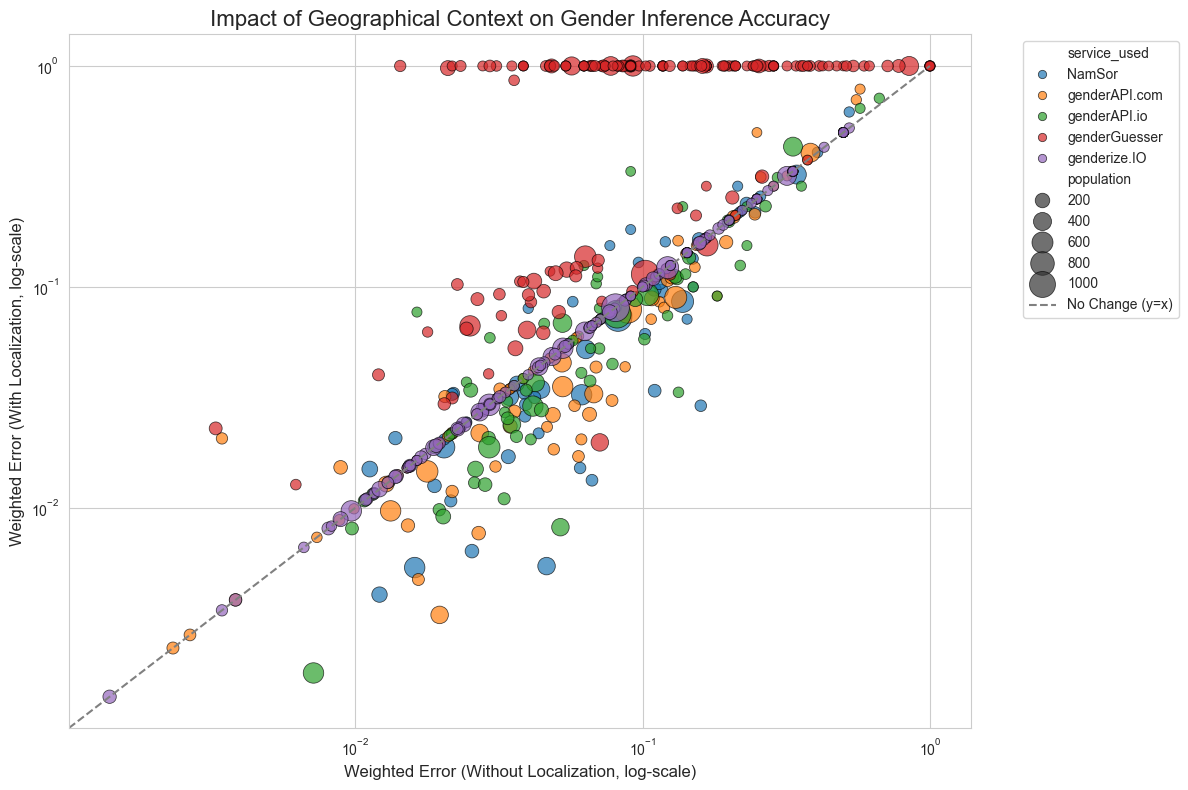

In [19]:
# 1. Transform the data
# We pivot the table so we have one column for 'False' (No Local) and one for 'True' (With Local)
# This aligns the data so every row represents ONE country for ONE tool.


df_pivot = df_metricPerCountry.pivot_table(
    index=['service_used', 'country', 'population'], 
    columns='useLocal', 
    values='weighted_error'
).reset_index()

# Rename the new columns for easier plotting
df_pivot = df_pivot.rename(columns={False: 'Error_No_Local', True: 'Error_With_Local'})

# 2. Setup the Plot
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# 3. Create the Scatter Plot
sns.scatterplot(
    data=df_pivot,
    x='Error_No_Local',
    y='Error_With_Local',
    hue='service_used',      # Color by Tool
    size='population',       # Size by N
    sizes=(50, 400),         # Min/Max size of bubbles
    alpha=0.7,               # Transparency to see overlapping points
    edgecolor='black'
)

# 4. Add the Diagonal Line (y=x)
# This line represents "No Change".
max_val = max(df_pivot['Error_No_Local'].max(), df_pivot['Error_With_Local'].max())
plt.plot([0, max_val], [0, max_val], color='gray', linestyle='--', label='No Change (y=x)')

# 5. Add Labels and Titles
plt.title('Impact of Geographical Context on Gender Inference Accuracy', fontsize=16)
plt.xlabel('Weighted Error (Without Localization, log-scale)', fontsize=12)
plt.ylabel('Weighted Error (With Localization, log-scale)', fontsize=12)
# plt.xlim((-0.1, 0.5))
# plt.ylim((-0.1, 0.5))
plt.xscale('log')
plt.yscale('log')


# Move legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

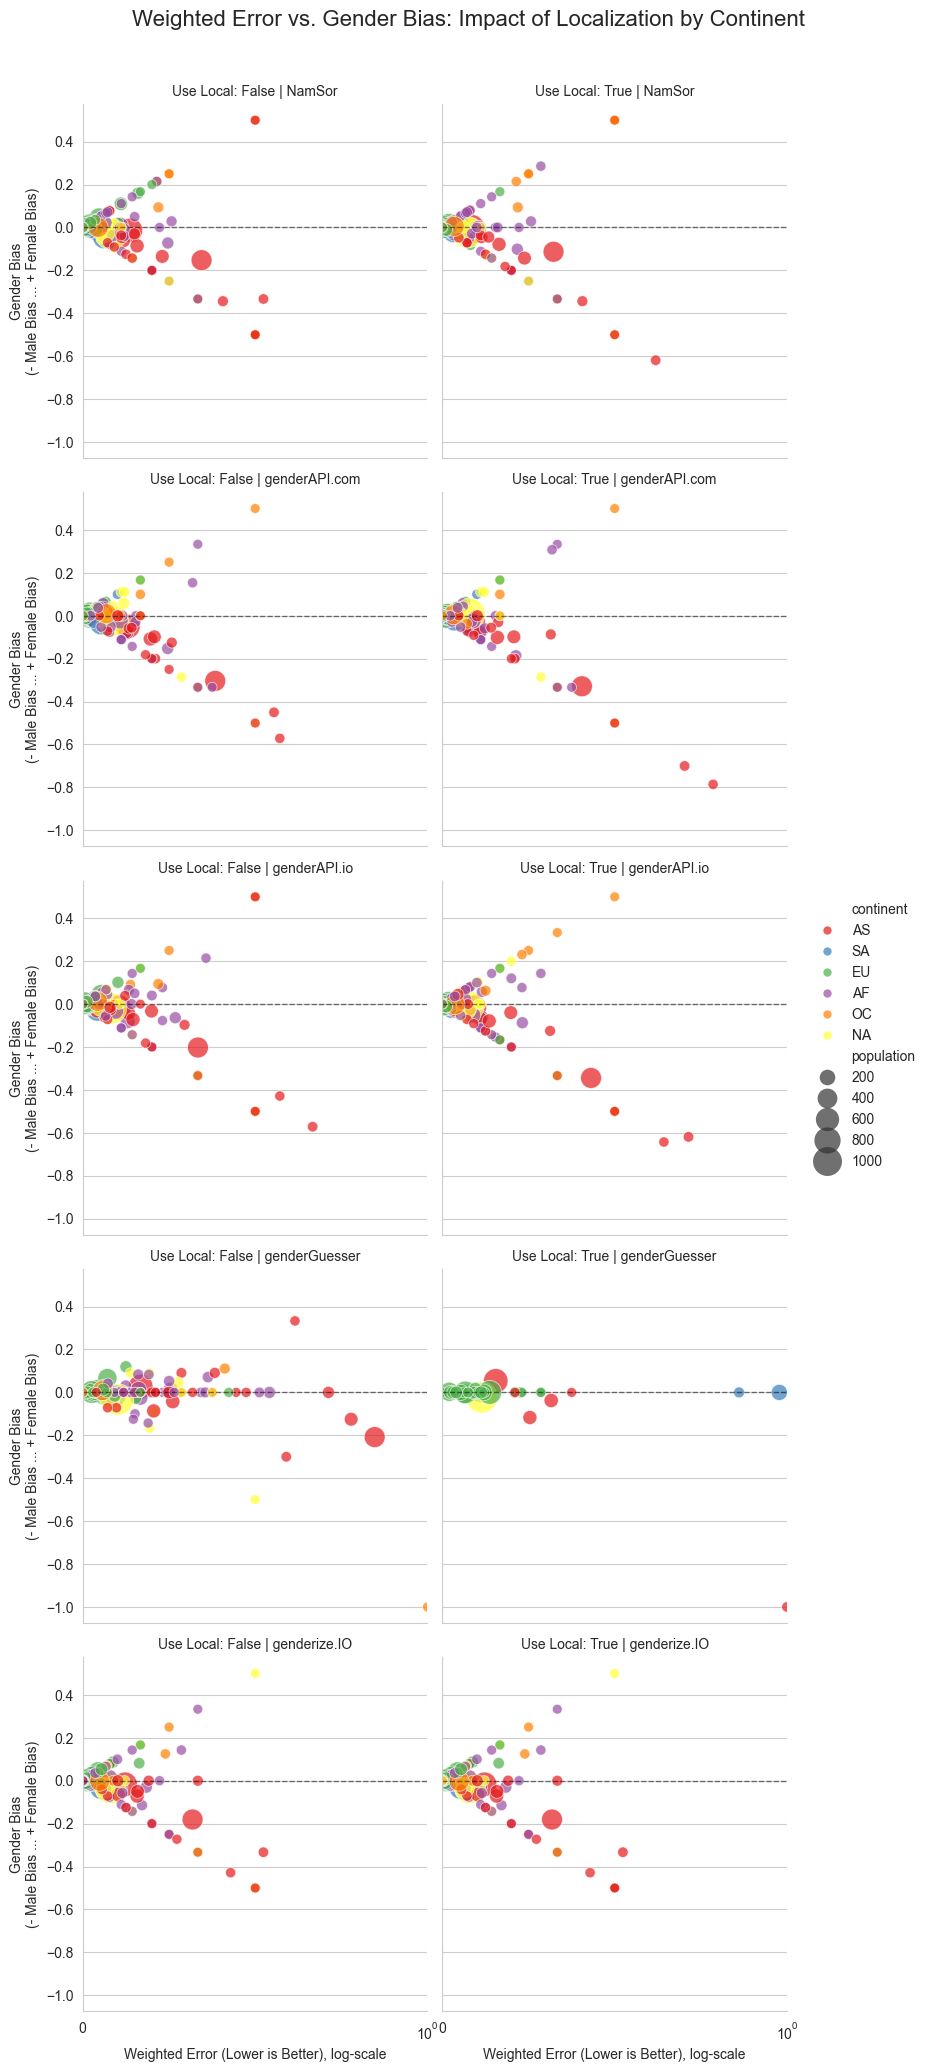

In [20]:
df = df_metricPerCountry.reset_index(drop=True)

# --- 2. Plotting ---
sns.set_style("whitegrid")

# Create the FacetGrid
g = sns.relplot(
    data=df,
    x='weighted_error',
    y='error_gender_bias',
    hue='continent',       # Color by Continent
    col='useLocal',    # Columns = Tools
    row='service_used',        # Rows = Conditions
    size='population',     # Bubble size
    sizes=(50, 500),       # Size range
    kind='scatter',
    palette='Set1',        # Distinct colors
    alpha=0.7,             # Transparency
    height=4,              # Height per subplot
    aspect=1
)

# --- 3. Customizations ---

# Add Reference Lines to ALL subplots
# Horizontal line at 0 (No Bias)
g.map(plt.axhline, y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
# Vertical line at 0 (Zero Error)
g.map(plt.axvline, x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)

# Titles and Labels
g.fig.suptitle('Weighted Error vs. Gender Bias: Impact of Localization by Continent', y=1.03, fontsize=16)
g.set_axis_labels("Weighted Error (Lower is Better), log-scale", "Gender Bias\n(- Male Bias ... + Female Bias)")
g.set_titles(col_template="{row_name}", row_template="Use Local: {col_name}")
g.set(xscale="symlog", xlim=(0, 1.0))

# Adjust Legend
# sns.relplot handles the legend automatically, but we can move it if needed.
# typically it places it outside to the right.

plt.show()

## Annexe 9 : 	Biais de genre par continent par outil, avec et sans l’origine connue

In [49]:
df_metricPerCountry.head(2).to_csv()

',service_used,country,useLocal,population,error_with_unknown,error_without_unknown,error_unknown,error_gender_bias,weighted_error,continent\r\n0,NamSor,BD,False,6.0,0.0,0.0,0.0,0.0,0.0,AS\r\n0,NamSor,PY,False,32.0,0.03125,0.03125,0.0,0.03125,0.03125,SA\r\n'

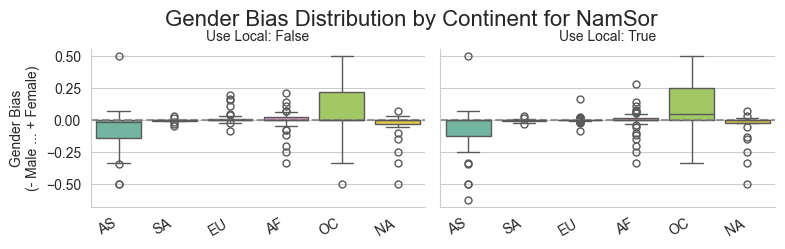

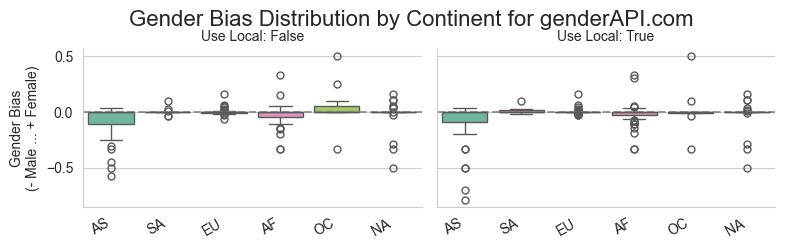

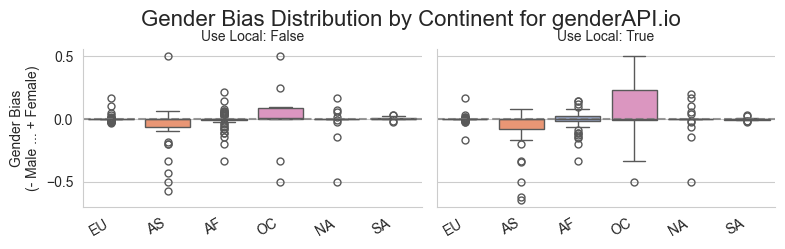

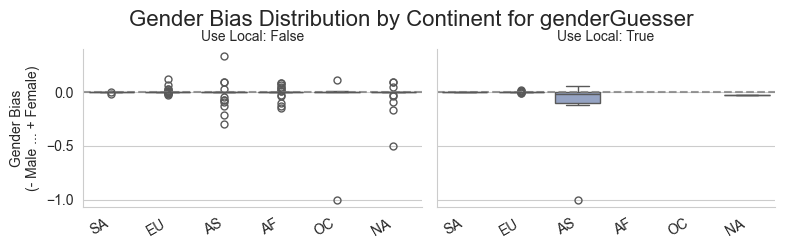

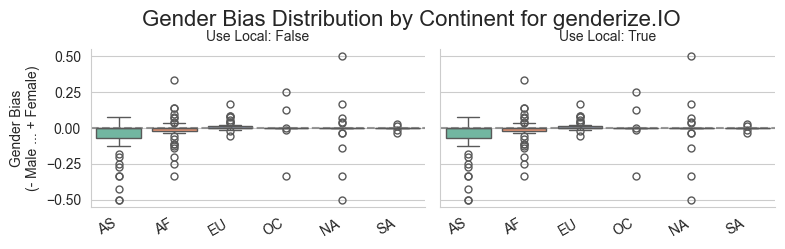

In [42]:
df = df_metricPerCountry.reset_index(drop=True)
sns.set_style("whitegrid")

# Get the list of unique services to iterate over
unique_services = df['service_used'].unique()
for service in unique_services:

    df_service = df[df['service_used'] == service]

    g = sns.catplot(
        data=df_service,
        x='continent',
        y='error_gender_bias',
        col='useLocal',      
        row='service_used',  
        kind='box',          
        hue='continent',    
        palette='Set2',      
        height=2.5,          
        aspect=1.6,          
        dodge=False,        
        margin_titles=True  
    )

    # --- Aesthetic Upgrades ---

    # 1. Add the "Zero Bias" Reference Line (Essential!)
    # This lets you instantly see if a continent is consistently "above" (Female Bias)
    # or "below" (Male Bias) the center.
    g.map(plt.axhline, y=0, color='gray', linestyle='--', linewidth=1.5, alpha=0.8)

    # 2. Fix Labels
    g.fig.suptitle(f'Gender Bias Distribution by Continent for {service}', y=1.02, fontsize=16)
    g.set_axis_labels("", "Gender Bias\n(- Male ... + Female)")
    g.set_titles(col_template="Use Local: {col_name}", row_template="")


    # 3. Rotate X-Axis Labels (to fit "North America" etc.)
    for ax in g.axes.flat:
        plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

    plt.show()

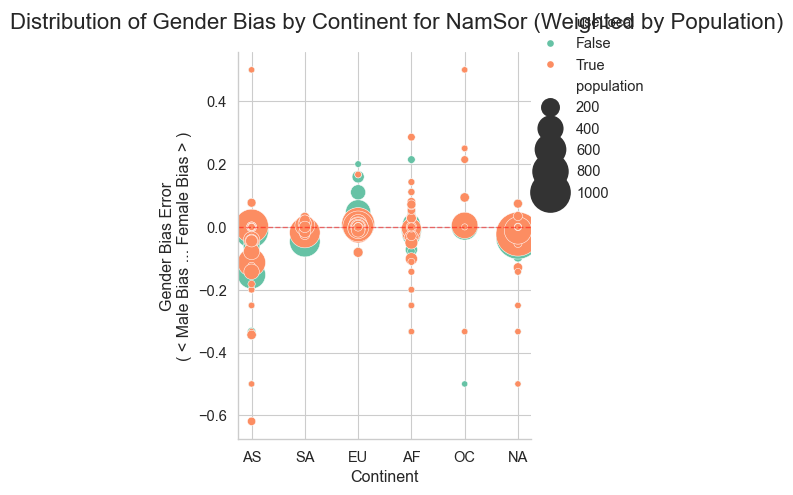

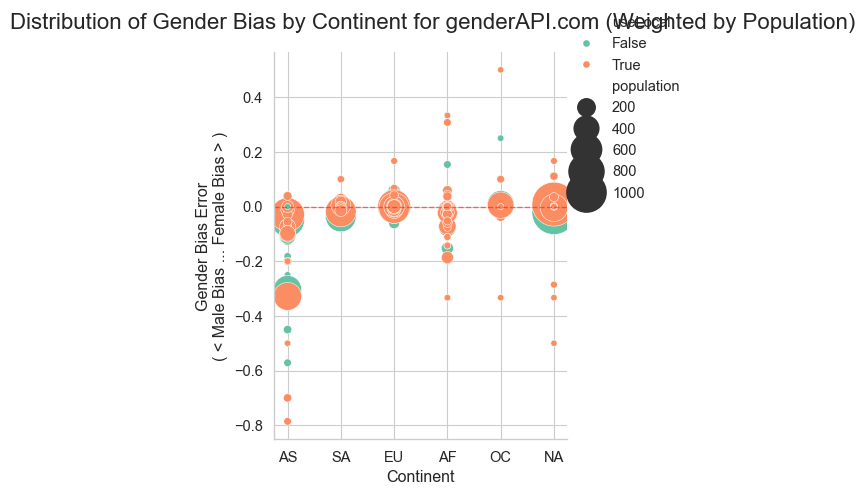

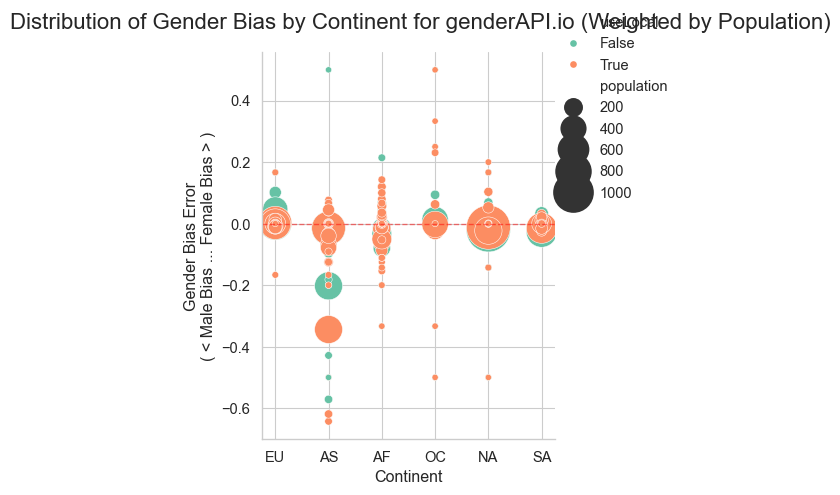

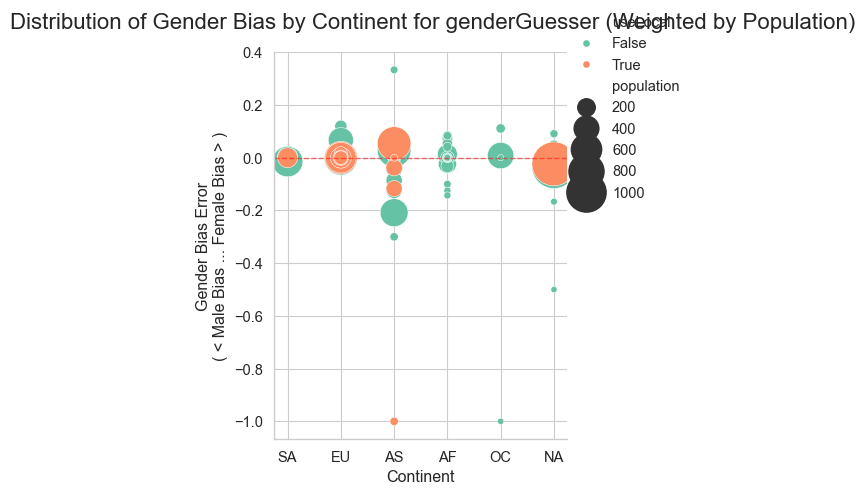

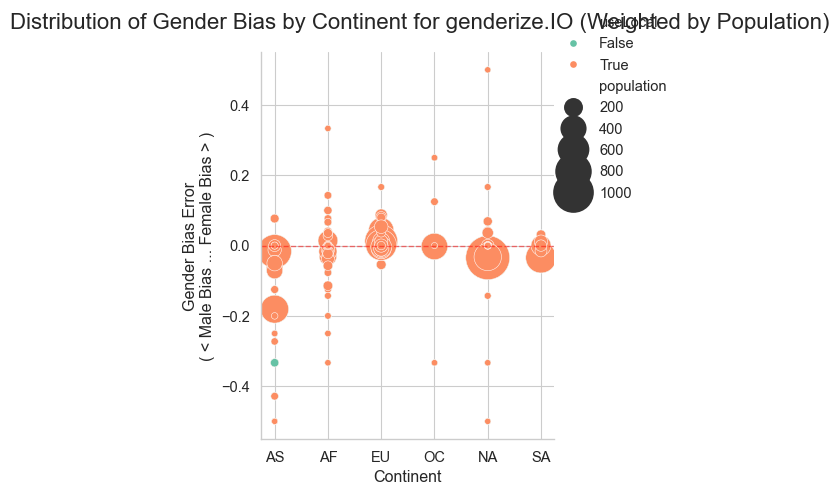

In [65]:
df = df_metricPerCountry.reset_index(drop=True)

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

# 3. Create the Bubble Strip Plot using relplot (Relational Plot)
# kind='scatter' creates the dots
# col='service_used' creates a separate plot for each tool
unique_services = df['service_used'].unique()
for service in unique_services:

    df_service = df[df['service_used'] == service]
    g = sns.relplot(
        data=df_service,
        x="continent",
        y="error_gender_bias",
        col="service_used",      # Facet by tool
        hue="useLocal",          # Color distinguishes context aware vs not
        size="population",       # Bubble size based on sample size
        sizes=(20, 1000),        # Range of bubble sizes (min, max) - adjust this!
        alpha=1.0,               # Transparency to see overlapping bubbles
        palette="Set2",       # Colorblind-friendly palette
        height=5,                # Height of each subplot
        aspect=0.8,              # Width aspect ratio
        col_wrap=1               # How many plots per row
    )

    # 4. Refine the visual elements
    # Add a vertical line at 0 (Neutral Bias) for every subplot
    for ax in g.axes.flat:

        ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
        # ax.text(0, -0.1, 'Neutral', color='red', ha='center', va='top', transform=ax.get_xaxis_transform(), fontsize=10)

    # 5. Clean up labels
    g.set_axis_labels("Continent", "Gender Bias Error\n( < Male Bias ... Female Bias > )")
    g.set_titles("") # Set title of each subplot to just the tool name

    # 6. Adjust the legend
    # Move legend to a better spot or keep it outside. 
    # Depending on population variance, the legend can get long, so we sometimes simplify it.
    sns.move_legend(g, "upper right", bbox_to_anchor=(1, 1))

    # 7. Final layout adjustment
    plt.subplots_adjust(top=0.9) # Make room for a main title if needed
    g.fig.suptitle(f'Distribution of Gender Bias by Continent for {service} (Weighted by Population)', fontsize=16)

    plt.show()

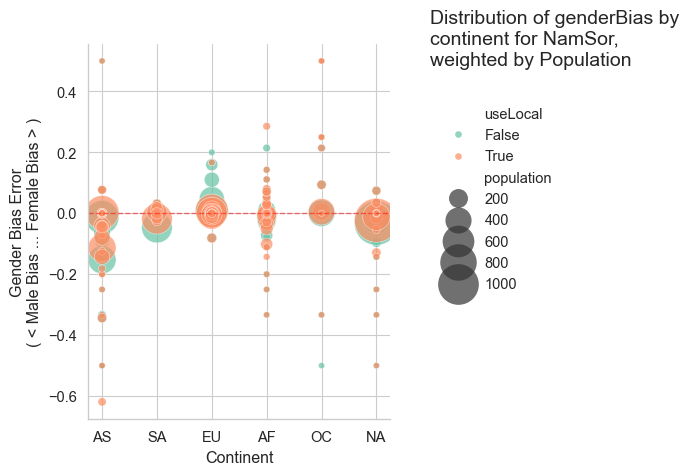

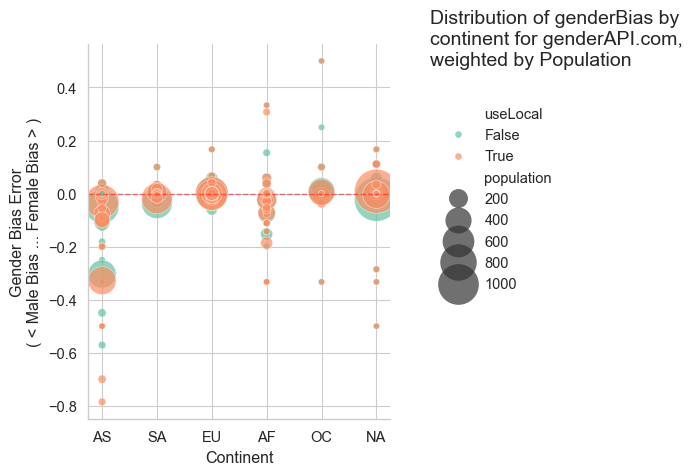

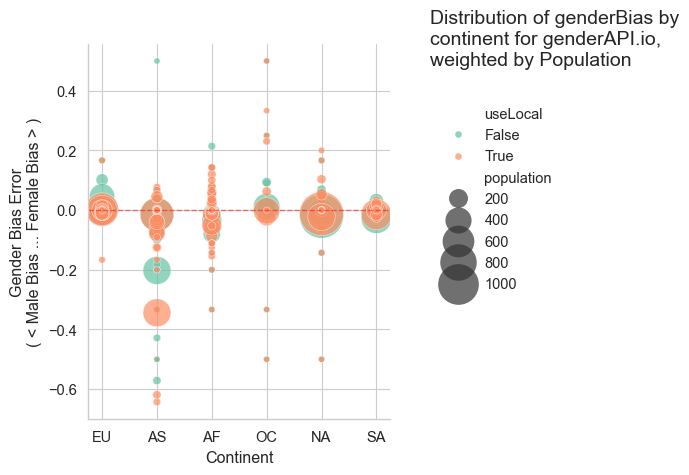

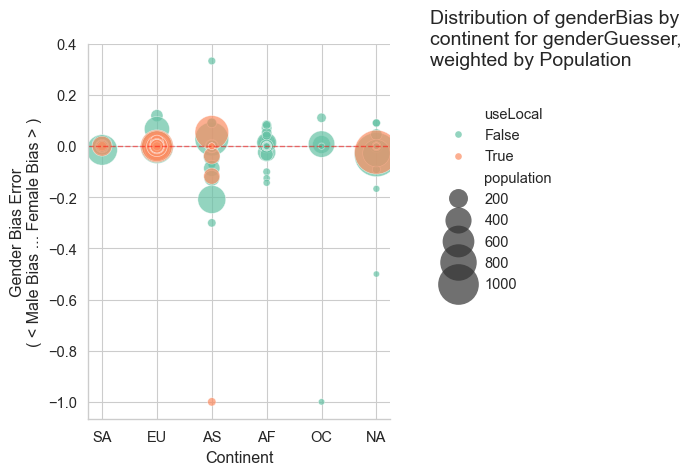

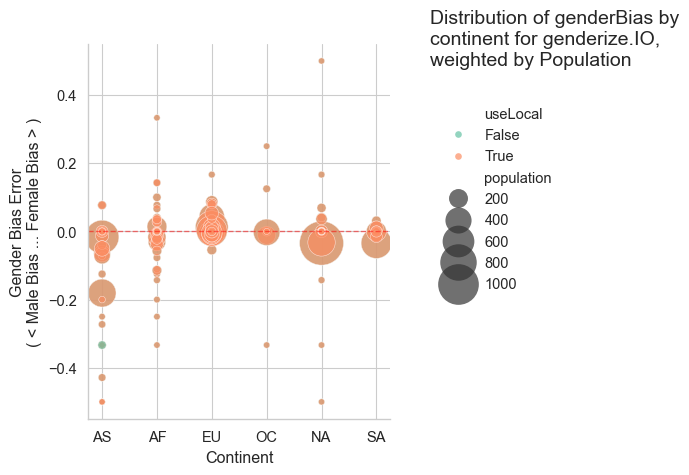

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already loaded
df = df_metricPerCountry.reset_index(drop=True)

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

unique_services = df['service_used'].unique()

for service in unique_services:
    df_service = df[df['service_used'] == service]
    
    # Create the plot
    g = sns.relplot(
        data=df_service,
        x="continent",
        y="error_gender_bias",
        col="service_used",
        hue="useLocal",
        size="population",
        sizes=(20, 1000),
        alpha=0.7,         
        palette="Set2",
        height=5,
        aspect=0.8,
        col_wrap=1,
        facet_kws={'legend_out': False} # We will manually handle the legend
    )

    # Refine visual elements
    for ax in g.axes.flat:
        ax.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)

    g.set_axis_labels("Continent", "Gender Bias Error\n( < Male Bias ... Female Bias > )")
    g.set_titles("") 

    # --- NEW LAYOUT LOGIC ---
    
    # 1. Resize the drawing area to create a "sidebar" on the right
    # 'right=0.65' means the plot stops at 65% of the width, leaving 35% empty for legend/text
    g.fig.subplots_adjust(right=0.95, top=0.9, bottom=0.15)

    # 2. Move the Legend into that sidebar
    # bbox_to_anchor=(x, y): x=1.05 puts it just outside the plot area
    sns.move_legend(
        g, 
        "upper left", 
        bbox_to_anchor=(1.05, 0.8), 
        frameon=False,
        title=None  # Remove internal legend title to make it cleaner
    )
    
    # 3. Add the Title above the Legend in the sidebar
    # We use g.fig.text(x, y, string) using figure coordinates (0 to 1)
    g.fig.text(
        1.05, 0.85,  # x=0.68 aligns it with the legend we moved to the sidebar
        f'Distribution of genderBias by\ncontinent for {service},\nweighted by Population', 
        fontsize=14, 
        fontweight='normal',
        ha='left',   # Left align text
        va='bottom'  # Align bottom of text to y coordinate
    )
    
    plt.show()

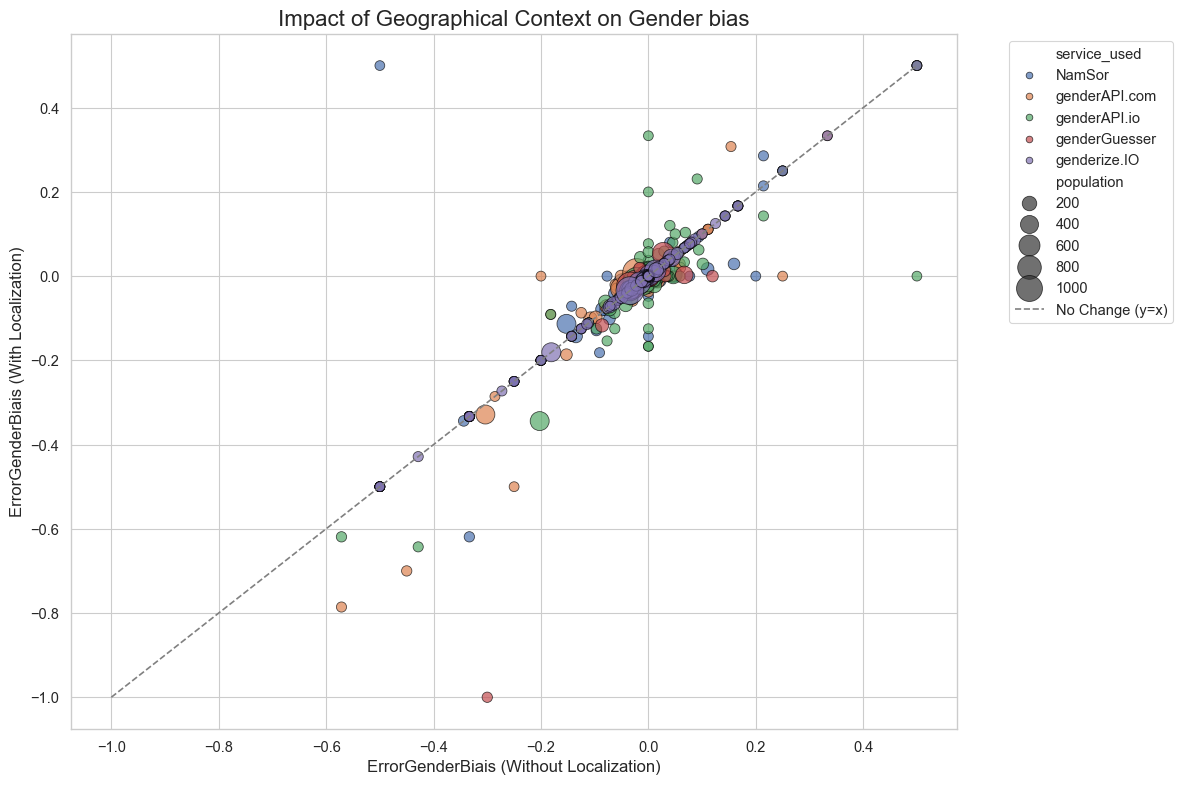

In [104]:
df_pivot_gender = df_metricPerCountry.pivot_table(
    index=['service_used', 'country', 'population'], 
    columns='useLocal', 
    values='error_gender_bias'
).reset_index()
df_pivot_gender = df_pivot_gender.rename(columns={False: 'Bias_without_Local', True: 'Bias_with_Local'})


plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# 3. Create the Scatter Plot
sns.scatterplot(
    data=df_pivot_gender,
    x='Bias_without_Local',
    y='Bias_with_Local',
    hue='service_used',      # Color by Tool
    size='population',       # Size by N
    sizes=(50, 400),         # Min/Max size of bubbles
    alpha=0.7,               # Transparency to see overlapping points
    edgecolor='black'
)

# 4. Add the Diagonal Line (y=x)
# This line represents "No Change".
max_val = max(df_pivot_gender['Bias_without_Local'].max(), df_pivot_gender['Bias_with_Local'].max())
min_val = min(df_pivot_gender['Bias_without_Local'].min(), df_pivot_gender['Bias_with_Local'].min())
plt.plot([min_val, max_val], [min_val, max_val], color='gray', linestyle='--', label='No Change (y=x)')



# 5. Add Labels and Titles
plt.title('Impact of Geographical Context on Gender bias', fontsize=16)
plt.xlabel('ErrorGenderBiais (Without Localization)', fontsize=12)
plt.ylabel('ErrorGenderBiais (With Localization)', fontsize=12)

# plt.yscale('symlog')
# plt.xscale('symlog')


# Move legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
checkPivot = df_metricPerCountry.pivot_table(
    index=['service_used', 'continent'],
    columns='useLocal',
    values='error_gender_bias',
    # aggfunc='median'
).reset_index()
checkPivot

checkPivot = checkPivot.rename(columns={True: "erreur_with_var", False: "erreur_without_var"})


# checkPivot['erreur_without_var'] = checkPivot['erreur_without_var']*100
# checkPivot['erreur_with_var'] = checkPivot['erreur_with_var'] * 100
checkPivot['diff'] = checkPivot['erreur_without_var'] - checkPivot['erreur_with_var']
checkPivot['diffAbs'] = np.abs(checkPivot['diff'])

checkPivot.sort_values(by=['continent', 'erreur_with_var']).round(4)

useLocal,service_used,continent,erreur_without_var,erreur_with_var,diff,diffAbs
6,genderAPI.com,AF,-0.0261,-0.0205,-0.0056,0.0056
24,genderize.IO,AF,-0.0111,-0.0111,0.0000,0.0000
12,genderAPI.io,AF,-0.0087,-0.0090,0.0002,0.0002
0,NamSor,AF,-0.0026,-0.0050,0.0024,0.0024
18,genderGuesser,AF,-0.0007,NaN,NaN,NaN
19,genderGuesser,AS,-0.0091,-0.1835,0.1744,0.1744
7,genderAPI.com,AS,-0.0873,-0.1015,0.0141,0.0141
25,genderize.IO,AS,-0.0804,-0.0804,0.0000,0.0000
1,NamSor,AS,-0.0737,-0.0802,0.0065,0.0065
13,genderAPI.io,AS,-0.0547,-0.0794,0.0247,0.0247


In [ ]:
checkPivot = df_metricPerCountry.pivot_table(
    index=['service_used', 'country'],
    columns='useLocal',
    values='error_gender_bias',
    # aggfunc='median'
).reset_index()
checkPivot.describe().round(4)

useLocal,False,True
count,939.0000,805.0000
mean,-0.0168,-0.0205
std,0.1151,0.1273
min,-1.0000,-1.0000
25%,-0.0045,-0.0098
50%,0.0000,0.0000
75%,0.0000,0.0000
max,0.5000,0.5000


In [156]:
checkPivot = df_metricPerCountry.pivot_table(
    index=['service_used', 'continent'],
    columns='useLocal',
    values='error_gender_bias',
    # aggfunc='median'
).reset_index()
checkPivot = checkPivot.rename(columns={True: "erreur_with_var", False: "erreur_without_var"})
checkPivot

checkPivPivot = checkPivot.pivot_table(
    index='service_used',
    columns='continent',
    values='erreur_with_var'
)
checkPivPivot.round(4).sort_values('AF')

continent,AF,AS,EU,NA,OC,SA
service_used,,,,,,
genderAPI.com,-0.0205,-0.1015,0.0047,-0.0258,0.0203,0.0119
genderize.IO,-0.0111,-0.0804,0.0103,-0.0088,0.0023,-0.0006
genderAPI.io,-0.0090,-0.0794,-0.0008,-0.0070,0.0432,0.0008
NamSor,-0.0050,-0.0802,0.0033,-0.0511,0.1238,0.0008
genderGuesser,NaN,-0.1835,0.0007,-0.0234,NaN,0.0000


In [165]:
checkPivot = df_metricPerCountry.pivot_table(
    index=['continent'],
    columns='useLocal',
    values='error_gender_bias',
).reset_index()
checkPivot

checkPivot = checkPivot.rename(columns={True: "erreur_with_var", False: "erreur_without_var"})


# checkPivot['erreur_without_var'] = checkPivot['erreur_without_var']*100
# checkPivot['erreur_with_var'] = checkPivot['erreur_with_var'] * 100
checkPivot['diff'] = checkPivot['erreur_without_var'] - checkPivot['erreur_with_var']
# checkPivot['diffAbs'] = np.abs(checkPivot['diff'])

checkPivot.sort_values(by=['continent']).round(4)

useLocal,continent,erreur_without_var,erreur_with_var,diff
0,AF,-0.0098,-0.0114,0.0015
1,AS,-0.0613,-0.0888,0.0275
2,EU,0.0082,0.0037,0.0045
3,NA,-0.0243,-0.0232,-0.0011
4,OC,0.0054,0.0480,-0.0425
5,SA,0.0012,0.0031,-0.0019


## Annexe 8 : 	Score générale par continent par outil, avec et sans l’origine connue

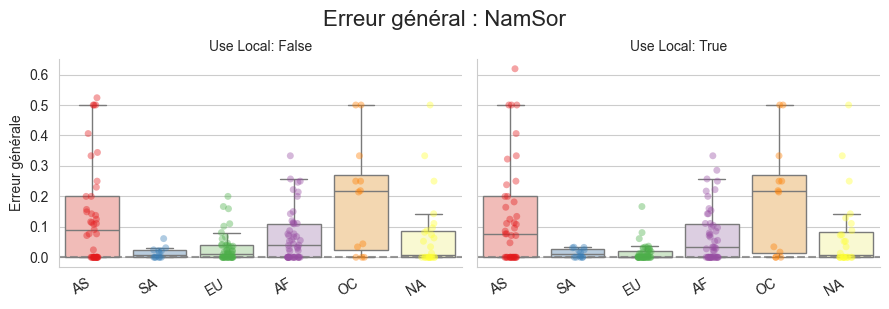

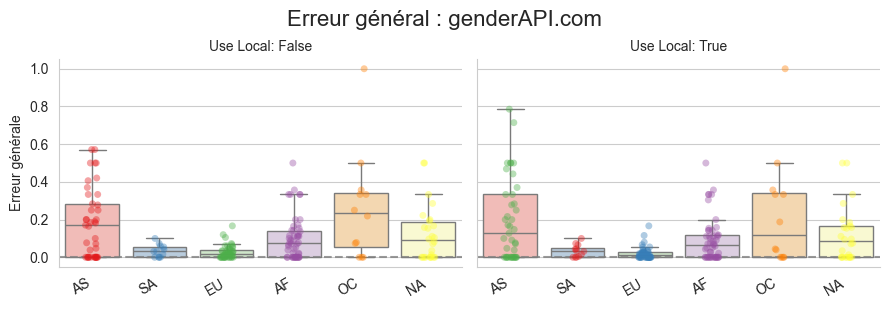

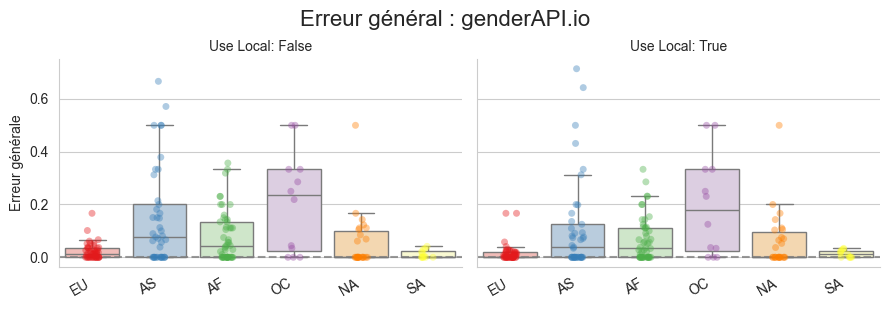

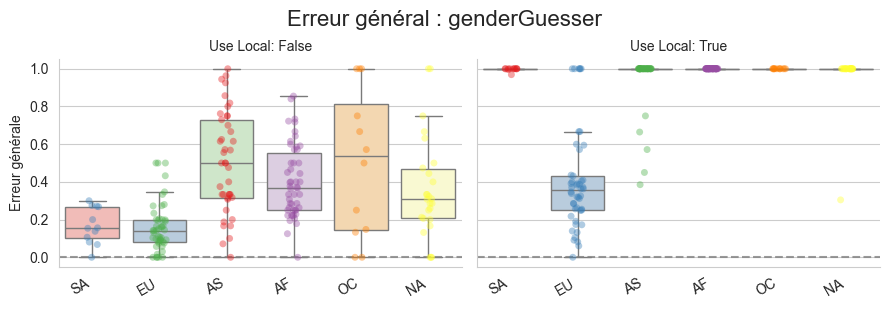

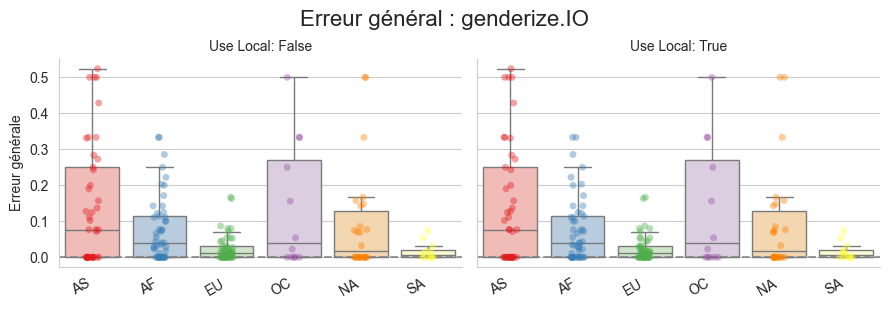

In [37]:
df = df_metricPerCountry.reset_index(drop=True)
sns.set_style("whitegrid")

# Get the list of unique services to iterate over
unique_services = df['service_used'].unique()

for service in unique_services:
    # 1. Filter data for the current service
    df_service = df[df['service_used'] == service]
    
    # 2. Plotting the specific service
    # Note: 'row' parameter is removed as we are separating them manually
    g = sns.catplot(
        data=df_service,
        x='continent',
        y='error_with_unknown',
        col='useLocal',
        kind='box',
        hue='continent',
        dodge=False,
        palette='Pastel1',   
        showfliers=False,    
        height=3,            # Adjusted slightly for better standalone visibility
        aspect=1.5
    )

    # Superpose the raw points
    g.map_dataframe(
        sns.stripplot,
        x='continent',
        y='error_with_unknown',
        hue='continent',
        palette='Set1',      
        alpha=0.4,            
        jitter=True,          
        dodge=False
    )

    # Add the horizontal line at y=0
    g.map(plt.axhline, y=0, color='gray', linestyle='--', linewidth=1.5, alpha=0.8)

    # 3. Titles and Labels
    # Dynamically set the title to include the Service Name
    g.fig.suptitle(f'Erreur général : {service}', y=1.05, fontsize=16)
    g.set_axis_labels("", "Erreur générale")
    g.set_titles(col_template="Use Local: {col_name}")

    # 4. Rotate X-Axis Labels
    for ax in g.axes.flat:
        plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

    plt.show()

In [118]:
checkPivot = df_metricPerCountry.pivot_table(
    index=['service_used', 'continent'],
    columns='useLocal',
    values='error_with_unknown',
    # aggfunc='median'
).reset_index()

checkPivot = checkPivot.rename(columns={True: "erreur_with_var", False: "erreur_without_var"})


# checkPivot['erreur_without_var'] = checkPivot['erreur_without_var']*100
# checkPivot['erreur_with_var'] = checkPivot['erreur_with_var'] * 100
checkPivot['diff'] = checkPivot['erreur_without_var'] - checkPivot['erreur_with_var']

checkPivot.sort_values(by=['service_used', 'continent']).round(4)

useLocal,service_used,continent,erreur_without_var,erreur_with_var,diff
0,NamSor,AF,0.0690,0.0715,-0.0025
1,NamSor,AS,0.1339,0.1350,-0.0011
2,NamSor,EU,0.0302,0.0141,0.0161
3,NamSor,NA,0.0708,0.0713,-0.0004
4,NamSor,OC,0.1954,0.1932,0.0022
5,NamSor,SA,0.0146,0.0135,0.0011
6,genderAPI.com,AF,0.1017,0.0945,0.0071
7,genderAPI.com,AS,0.1803,0.1930,-0.0126
8,genderAPI.com,EU,0.0274,0.0204,0.0070
9,genderAPI.com,NA,0.1241,0.1207,0.0034


In [114]:
checkPivot.describe().round(4)

useLocal,erreur_without_var,erreur_with_var,diff
count,939.0000,805.0000,805.0000
mean,-0.0168,-0.0205,0.0027
std,0.1151,0.1273,0.0580
min,-1.0000,-1.0000,-1.0000
25%,-0.0045,-0.0098,0.0000
50%,0.0000,0.0000,0.0000
75%,0.0000,0.0000,0.0000
max,0.5000,0.5000,0.7000


In [26]:
df_metricPerCountry.loc[(df_metricPerCountry['service_used']=='genderGuesser') & (df_metricPerCountry['continent']=='AF')]

,service_used,country,useLocal,population,error_with_unknown,error_without_unknown,error_unknown,error_gender_bias,weighted_error,continent
0,genderGuesser,SZ,False,2.0,0.500000,0.000000,0.500000,0.000000,0.166667,AF
0,genderGuesser,LS,False,3.0,0.666667,0.000000,0.666667,0.000000,0.285714,AF
0,genderGuesser,ST,False,3.0,0.333333,0.000000,0.333333,0.000000,0.090909,AF
0,genderGuesser,ML,False,46.0,0.717391,0.071429,0.695652,0.071429,0.362745,AF
0,genderGuesser,MZ,False,14.0,0.285714,0.000000,0.285714,0.000000,0.074074,AF
...,...,...,...,...,...,...,...,...,...,...
0,genderGuesser,RW,True,19.0,1.000000,NaN,1.000000,NaN,1.000000,AF
0,genderGuesser,SD,True,15.0,1.000000,NaN,1.000000,NaN,1.000000,AF
0,genderGuesser,SO,True,5.0,1.000000,NaN,1.000000,NaN,1.000000,AF
0,genderGuesser,CM,True,28.0,1.000000,NaN,1.000000,NaN,1.000000,AF


# Other

In [45]:
stat_df, metric_df = manager.runAnalysis(masterdf=df_master_noUnknown)

c:\Users\brief\Desktop\Master\Ecole\Semestre3\M8_ProjetDeRecherche\code_ProjetDeRecherche\notebooks\helpers\evaluator.py:20: SyntaxWarning: invalid escape sequence '\ '
  """


In [35]:
metric_df

,service_used,source,useLocal,error_with_unknown,error_without_unknown,error_unknown,error_gender_bias,weighted_error
0,NamSor,kaggle,True,0.054417,0.054417,0.000000,-0.011016,0.054417
0,NamSor,kaggle,False,0.067056,0.067056,0.000000,-0.009359,0.067056
0,NamSor,wikidata,True,0.060631,0.060631,0.000000,-0.015089,0.060631
0,NamSor,wikidata,False,0.069596,0.069596,0.000000,-0.018288,0.069596
0,genderAPI.com,kaggle,True,0.074192,0.047198,0.028332,-0.019061,0.052722
0,genderAPI.com,kaggle,False,0.084563,0.058757,0.027417,-0.021623,0.064034
0,genderAPI.com,wikidata,True,0.084643,0.055477,0.030880,-0.027596,0.061458
0,genderAPI.com,wikidata,False,0.090170,0.061321,0.030734,-0.029350,0.067236
0,genderAPI.io,kaggle,True,0.053101,0.053101,0.000000,-0.019610,0.053101
0,genderAPI.io,kaggle,False,0.068267,0.055053,0.013984,-0.010609,0.057726


In [36]:
stat_df

,service_used,source,statistic,p_value,b,c,odds_ratio,cohen_g,ci_low,ci_high
0,NamSor,kaggle,40.0,5.639881e-17,40,154,3.850000,0.587629,2.718944,5.451565
0,NamSor,wikidata,16.0,2.397320e-06,16,56,3.500000,0.555556,2.008032,6.100500
0,genderAPI.com,kaggle,77.0,1.643869e-09,77,172,2.233766,0.381526,1.707347,2.922495
0,genderAPI.com,wikidata,31.0,2.138319e-02,31,53,1.709677,0.261905,1.097602,2.663075
0,genderAPI.io,kaggle,118.0,1.062283e-12,118,255,2.161017,0.367292,1.737342,2.688011
0,genderAPI.io,wikidata,57.0,1.000000e+00,58,57,0.982759,-0.008696,0.681849,1.416464
0,genderGuesser,kaggle,719.0,0.000000e+00,3541,719,0.203050,-0.662441,0.187406,0.220000
0,genderGuesser,wikidata,300.0,9.136835e-238,1704,300,0.176056,-0.700599,0.155724,0.199043
0,genderize.IO,kaggle,0.0,1.000000e+00,0,0,inf,NaN,NaN,NaN
0,genderize.IO,wikidata,0.0,1.000000e+00,0,0,inf,NaN,NaN,NaN


## Mean of the base metric

In [40]:
mean_df = manager.getMeanMetric(metric_df)
mean_df.sort_values(by='error_with_unknown')

,service,error_with_unknown,error_without_unknown,error_unknown,error_gender_bias,weighted_error
0,NamSor,0.062925,0.062925,0.000000,-0.013438,0.062925
0,genderAPI.io,0.065183,0.061387,0.004024,-0.018977,0.062154
0,genderize.IO,0.069170,0.058141,0.011708,-0.016927,0.060368
0,genderAPI.com,0.083392,0.055688,0.029341,-0.024408,0.061362
0,genderGuesser,0.448059,0.030644,0.429680,-0.002361,0.178460


In [41]:
mean_df.columns

Index(['service', 'error_with_unknown', 'error_without_unknown',
       'error_unknown', 'error_gender_bias', 'weighted_error'],
      dtype='object')

In [42]:
N = 256
vals = np.ones((N, 4))

# Replace these by your two actual colors
start = np.array([160, 71, 64]) / 255    # normalize properly
end   = np.array([2, 79, 116]) / 255  # usually 1,1,1

for i in range(3):
    vals[:, i] = np.linspace(start[i], end[i], N)

postercmp = ListedColormap(vals)

In [43]:
test = manager.getMeanMetricPerState(metric_df)
test.sort_values(by=['service', 'useLocal'])

,service,useLocal,error_with_unknown,error_without_unknown,error_unknown,error_gender_bias,weighted_error
0,NamSor,False,0.068326,0.068326,0.000000,-0.013824,0.068326
0,NamSor,True,0.057524,0.057524,0.000000,-0.013052,0.057524
0,genderAPI.com,False,0.087367,0.060039,0.029075,-0.025487,0.065635
0,genderAPI.com,True,0.079418,0.051337,0.029606,-0.023328,0.057090
0,genderAPI.io,False,0.068424,0.061343,0.007500,-0.014966,0.062774
0,genderAPI.io,True,0.061942,0.061431,0.000549,-0.022988,0.061533
0,genderGuesser,False,0.273067,0.036166,0.245791,-0.002630,0.095144
0,genderGuesser,True,0.623050,0.025122,0.613569,-0.002092,0.261776
0,genderize.IO,False,0.069105,0.057843,0.011953,-0.016574,0.060117
0,genderize.IO,True,0.069235,0.058439,0.011463,-0.017280,0.060618


In [44]:
pourcent_df = mean_df.loc[:, mean_df.columns!='service' ] * 100

showcase_df = pd.concat([mean_df['service'], pourcent_df], axis=1)

showcase_df.reset_index(inplace=True)
showcase_df.sort_values(by='error_with_unknown', inplace=True)
headers = {
    "selector": "th:not(.index_name)",
    "props": "background-color: #c0c1c4; color: black;"
}

error_with_unknown = 'EG %'
error_without_unknown = 'E-NC'
showcase_df = showcase_df.rename(columns={
    'service' : 'outil',
    'error_with_unknown' : error_with_unknown, 
    'error_without_unknown' : error_without_unknown
})
showcase_df.style.hide(axis='index').format({
    error_with_unknown: "{:.2f} %",
    error_without_unknown: "{:.2f} %",
    "error_unknown": "{:.2f} %",
    "error_gender_bias": "{:.2f}",
    "weighted_error": "{:.2f} %",
}).background_gradient(subset=[error_with_unknown, error_without_unknown], cmap='RdYlGn_r').set_table_styles([headers])


index,outil,EG %,E-NC,error_unknown,error_gender_bias,weighted_error
0,NamSor,6.29 %,6.29 %,0.00 %,-1.34,6.29 %
0,genderAPI.io,6.52 %,6.14 %,0.40 %,-1.90,6.22 %
0,genderize.IO,6.92 %,5.81 %,1.17 %,-1.69,6.04 %
0,genderAPI.com,8.34 %,5.57 %,2.93 %,-2.44,6.14 %
0,genderGuesser,44.81 %,3.06 %,42.97 %,-0.24,17.85 %


In [199]:
pourcent_df = test.loc[:, test.columns.drop(['service', 'useLocal'])] * 100

showcase_df = pd.concat([test[['service', 'useLocal']], pourcent_df], axis=1)

showcase_df.reset_index(inplace=True)

showcase_df.sort_values(by=['useLocal'], inplace=True)

headers = {
    "selector": "th:not(.index_name)",
    "props": "background-color: #c0c1c4; color: black;"
}

error_with_unknown = 'error %'
error_without_unknown = 'error % no unknown'
showcase_df = showcase_df.rename(columns={
    'service' : 'outil',
    'error_with_unknown' : error_with_unknown, 
    'error_without_unknown' : error_without_unknown
})
showcase_df.style.hide(axis='index').format({
    error_with_unknown: "{:.2f} %",
    error_without_unknown: "{:.2f} %",
    "error_unknown": "{:.2f} %",
    "error_gender_bias": "{:.2f}",
    "weighted_error": "{:.2f} %",
}).background_gradient(subset=[error_with_unknown, error_without_unknown], cmap='RdYlGn_r').set_table_styles([headers])


index,outil,useLocal,error %,error % no unknown,error_unknown,error_gender_bias,weighted_error
0,genderize.IO,False,6.91 %,5.78 %,1.20 %,-1.66,6.01 %
0,genderGuesser,False,27.31 %,3.62 %,24.58 %,-0.26,9.51 %
0,genderAPI.io,False,6.84 %,6.13 %,0.75 %,-1.50,6.28 %
0,genderAPI.com,False,8.74 %,6.00 %,2.91 %,-2.55,6.56 %
0,NamSor,False,6.83 %,6.83 %,0.00 %,-1.38,6.83 %
0,genderize.IO,True,6.92 %,5.84 %,1.15 %,-1.73,6.06 %
0,genderGuesser,True,62.30 %,2.51 %,61.36 %,-0.21,26.18 %
0,genderAPI.io,True,6.19 %,6.14 %,0.05 %,-2.30,6.15 %
0,genderAPI.com,True,7.94 %,5.13 %,2.96 %,-2.33,5.71 %
0,NamSor,True,5.75 %,5.75 %,0.00 %,-1.31,5.75 %


# Base metric without unknown

In [200]:
stat_NoUnknown_df, metric_NoUnknown_df = manager.runAnalysisWithoutUnknown(df_master_noUnknown) # the unknown here refer to different things
# the unknown on the master_df are unknown in the index (from a blunder of mine)
# the unknown in the metric and stat dfs are the version of those metrics where non-classifications are not taken into account

In [201]:
stat_NoUnknown_df

,service_used,source,statistic,p_value,b,c,odds_ratio,cohen_g,ci_low,ci_high
0,NamSor,kaggle,40.0,5.639881e-17,40,154,3.850000,0.587629,2.718944,5.451565
0,NamSor,wikidata,16.0,2.397320e-06,16,56,3.500000,0.555556,2.008032,6.100500
0,genderAPI.com,kaggle,64.0,1.266289e-11,64,166,2.593750,0.443478,1.943941,3.460773
0,genderAPI.com,wikidata,29.0,1.063749e-02,29,53,1.827586,0.292683,1.162159,2.874022
0,genderAPI.io,kaggle,118.0,1.504493e-03,118,173,1.466102,0.189003,1.160203,1.852654
0,genderAPI.io,wikidata,56.0,1.000000e+00,56,56,1.000000,0.000000,0.690455,1.448321
0,genderGuesser,kaggle,46.0,1.504186e-04,46,91,1.978261,0.328467,1.387684,2.820178
0,genderGuesser,wikidata,29.0,1.000000e+00,29,29,1.000000,0.000000,0.597667,1.673172
0,genderize.IO,kaggle,0.0,1.000000e+00,0,0,inf,NaN,NaN,NaN
0,genderize.IO,wikidata,0.0,1.000000e+00,0,0,inf,NaN,NaN,NaN


In [202]:
metric_NoUnknown_df

,service_used,source,useLocal,error_with_unknown,error_without_unknown,error_unknown,error_gender_bias,weighted_error
0,NamSor,kaggle,True,0.054417,0.054417,0.0,-0.011016,0.054417
0,NamSor,kaggle,False,0.067056,0.067056,0.0,-0.009359,0.067056
0,NamSor,wikidata,True,0.060631,0.060631,0.0,-0.015089,0.060631
0,NamSor,wikidata,False,0.069596,0.069596,0.0,-0.018288,0.069596
0,genderAPI.com,kaggle,True,0.047198,0.047198,0.0,-0.019061,0.047198
0,genderAPI.com,kaggle,False,0.058757,0.058757,0.0,-0.021623,0.058757
0,genderAPI.com,wikidata,True,0.055477,0.055477,0.0,-0.027596,0.055477
0,genderAPI.com,wikidata,False,0.061321,0.061321,0.0,-0.029350,0.061321
0,genderAPI.io,kaggle,True,0.053101,0.053101,0.0,-0.019610,0.053101
0,genderAPI.io,kaggle,False,0.055053,0.055053,0.0,-0.010609,0.055053


## Mean of the base metric without unknown

In [203]:
manager.getMeanMetric(metric_NoUnknown_df).sort_values(by='error_with_unknown')

,service,error_with_unknown,error_without_unknown,error_unknown,error_gender_bias,weighted_error
0,genderGuesser,0.030644,0.030644,0.0,-0.002361,0.030644
0,genderAPI.com,0.055688,0.055688,0.0,-0.024408,0.055688
0,genderize.IO,0.058141,0.058141,0.0,-0.016927,0.058141
0,genderAPI.io,0.061387,0.061387,0.0,-0.018977,0.061387
0,NamSor,0.062925,0.062925,0.0,-0.013438,0.062925


# Plotting for the poster

In [204]:
# genderGuesser throws a bit of a wrench in the machine here. We'll remove it for now
df_master_noGG = df_master_noUnknown.loc[
    (df_master_noUnknown['serviceUsed']!='genderGuesser'),
    # (df_master_noUnknown['predictedGender']!='unknown'), 
    :]

grouped = (
    df_master_noGG.groupby(["serviceUsed", "localization", "useLocalization"])
    ["isCorrect"]
    .sum()
    .reset_index()
)

pivoted = grouped.pivot_table(
    index=["serviceUsed", "localization"],
    columns="useLocalization",
    values="isCorrect",
    fill_value=0
).reset_index()

pivoted.columns.name = None
pivoted = pivoted.rename(columns={True: "correct_with_var", False: "correct_without_var"})

pivoted["improvement"] = pivoted["correct_with_var"] - pivoted["correct_without_var"]

country_impact = (
    pivoted.groupby("localization")["improvement"]
    .sum()
    .reset_index()
    .sort_values(by="improvement", ascending=False)
)

display(country_impact)
pivoted

,localization,improvement
91,JP,73.0
88,IT,37.0
187,US,33.0
25,BR,31.0
10,AU,21.0
...,...,...
42,CU,-3.0
183,TW,-3.0
99,KR,-6.0
167,SS,-22.0


,serviceUsed,localization,correct_without_var,correct_with_var,improvement
0,NamSor,AD,2.0,2.0,0.0
1,NamSor,AE,4.0,4.0,0.0
2,NamSor,AF,10.0,10.0,0.0
3,NamSor,AG,5.0,5.0,0.0
4,NamSor,AI,2.0,2.0,0.0
...,...,...,...,...,...
795,genderize.IO,WS,7.0,7.0,0.0
796,genderize.IO,YE,3.0,3.0,0.0
797,genderize.IO,ZA,197.0,197.0,0.0
798,genderize.IO,ZM,29.0,29.0,0.0


In [205]:
order_impact = country_impact.sort_values(by='improvement', ascending=False).reset_index()
order_impact

,index,localization,improvement
0,91,JP,73.0
1,88,IT,37.0
2,187,US,33.0
3,25,BR,31.0
4,10,AU,21.0
...,...,...,...
195,42,CU,-3.0
196,183,TW,-3.0
197,99,KR,-6.0
198,167,SS,-22.0


In [206]:
positive_impact =order_impact.loc[order_impact['improvement']>0,]
positive_impact['improvement'][5:,].sum()

np.float64(270.0)

In [207]:
positive_impact[['localization', 'improvement']].to_csv("C:/Users/brief/Desktop/Stuff I Like/The good stuff/lol.csv")

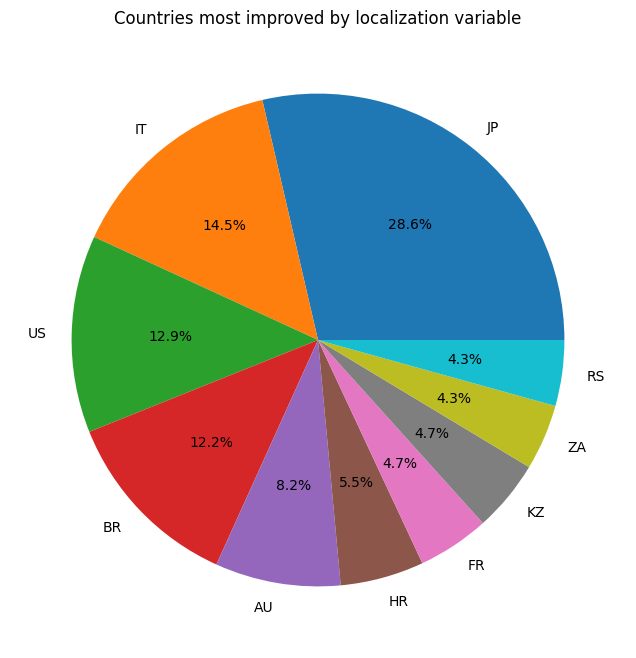

In [208]:
import matplotlib.pyplot as plt

top_countries = country_impact.head(10)  # top 10 most impacted
plt.figure(figsize=(8, 8))
plt.pie(top_countries["improvement"], labels=top_countries["localization"], autopct='%1.1f%%')
plt.title("Countries most improved by localization variable")
plt.show()

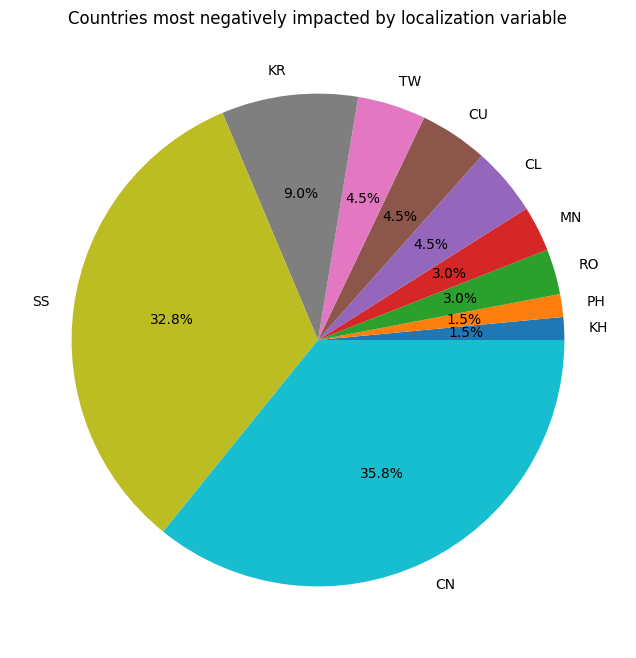

In [209]:
import matplotlib.pyplot as plt

top_countries = country_impact.tail(10)
plt.figure(figsize=(8, 8))
plt.pie(top_countries["improvement"]*-1, labels=top_countries["localization"], autopct='%1.1f%%')
plt.title("Countries most negatively impacted by localization variable")
plt.show()

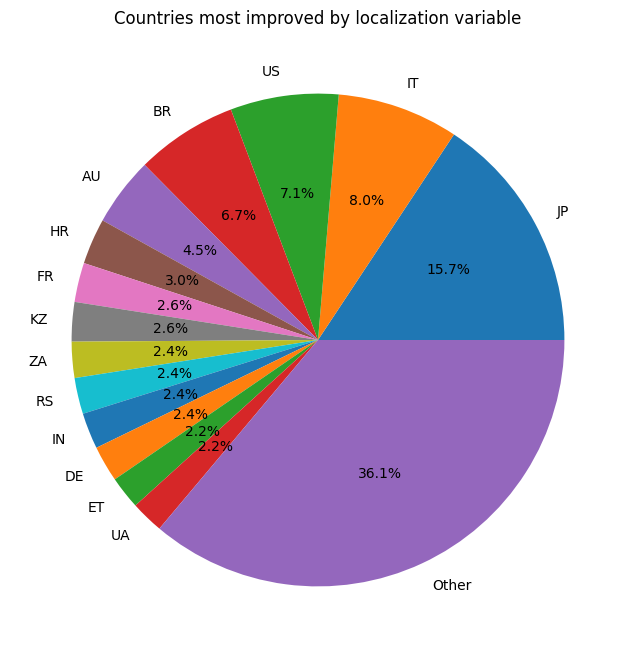

In [210]:
import matplotlib.pyplot as plt

top_countries = country_impact[country_impact['improvement']>0]
threshold = 10   # absolute threshold

vals = top_countries["improvement"]
labels = top_countries["localization"]

# Select large and small slices
large_mask = vals >= threshold
large_vals = vals[large_mask]
large_labels = labels[large_mask]

small_vals = vals[~large_mask]

# Add "Other" if needed
if len(small_vals) > 0:
    large_vals = pd.concat([large_vals, pd.Series([small_vals.sum()])], ignore_index=True)
    large_labels = pd.concat([large_labels, pd.Series(["Other"])], ignore_index=True)

# Plot
plt.figure(figsize=(8,8))
plt.pie(large_vals, labels=large_labels, autopct='%1.1f%%')
plt.title("Countries most improved by localization variable")
plt.show()

,serviceUsed,localization,correct_without_var,correct_with_var,improvement,n_without_var,n_with_var
0,NamSor,AD,2.0,2.0,0.0,2.0,2.0
1,NamSor,AE,4.0,4.0,0.0,5.0,5.0
2,NamSor,AF,10.0,10.0,0.0,10.0,10.0
3,NamSor,AG,5.0,5.0,0.0,5.0,5.0
4,NamSor,AI,2.0,2.0,0.0,2.0,2.0
...,...,...,...,...,...,...,...
795,genderize.IO,WS,7.0,7.0,0.0,14.0,14.0
796,genderize.IO,YE,3.0,3.0,0.0,3.0,3.0
797,genderize.IO,ZA,197.0,197.0,0.0,219.0,219.0
798,genderize.IO,ZM,29.0,29.0,0.0,35.0,35.0


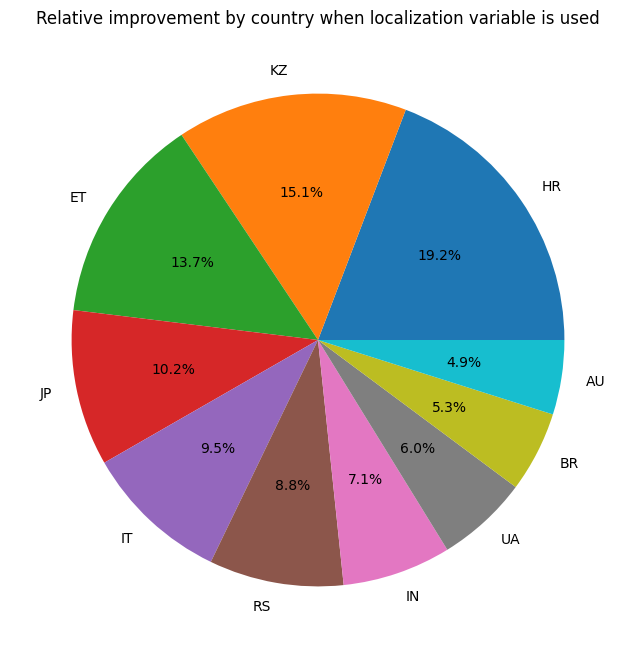

In [ ]:
# Step 1: Count how many total cases per (service, country, localization usage)
counts = (
    df_master_noGG.groupby(["serviceUsed", "localization", "useLocalization"])
    .size()
    .reset_index(name="n_cases")
)



# Step 2: merge those counts into the pivoted dataframe
pivoted = pivoted.merge(
    counts.pivot_table(
        index=["serviceUsed", "localization"],
        columns="useLocalization",
        values="n_cases",
        fill_value=0
    ).reset_index().rename(columns={True: "n_with_var", False: "n_without_var"}),
    on=["serviceUsed", "localization"],
    how="left"
)

# Step 3: compute improvement ratios
pivoted["improvement_abs"] = pivoted["correct_with_var"] - pivoted["correct_without_var"]
pivoted["improvement_ratio"] = pivoted["improvement_abs"] / (
    pivoted["n_with_var"] + pivoted["n_without_var"]
)

# Optional: percentage form
pivoted["improvement_pct"] = pivoted["improvement_ratio"] * 100

# Step 4: if you want per-country view across all services
country_impact = (
    pivoted.groupby("localization")[["improvement_abs", "improvement_ratio"]]
    .mean()
    .reset_index()
    .sort_values(by="improvement_ratio", ascending=False)
)



# Then you can easily visualize:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
top_countries = country_impact[country_impact['improvement_abs']>2].head(10)
plt.pie(
    top_countries["improvement_ratio"],
    labels=top_countries["localization"],
    autopct="%1.1f%%",
)
plt.title("Relative improvement by country when localization variable is used")
plt.show()


In [168]:
pivoted.sort_values(by='improvement_pct', ascending=True)

,serviceUsed,localization,correct_without_var,correct_with_var,improvement,n_without_var,n_with_var,improvement_abs,improvement_ratio,improvement_pct
367,genderAPI.com,SS,23.0,0.0,-23.0,25.0,0.0,-23.0,-0.920000,-92.000000
294,genderAPI.com,KH,3.0,2.0,-1.0,4.0,4.0,-1.0,-0.125000,-12.500000
383,genderAPI.com,TW,6.0,3.0,-3.0,14.0,14.0,-3.0,-0.107143,-10.714286
403,genderAPI.io,AG,5.0,4.0,-1.0,5.0,5.0,-1.0,-0.100000,-10.000000
415,genderAPI.io,BD,6.0,5.0,-1.0,6.0,6.0,-1.0,-0.083333,-8.333333
...,...,...,...,...,...,...,...,...,...,...
576,genderAPI.io,TL,2.0,3.0,1.0,3.0,3.0,1.0,0.166667,16.666667
503,genderAPI.io,LA,1.0,2.0,1.0,2.0,2.0,1.0,0.250000,25.000000
476,genderAPI.io,HK,1.0,2.0,1.0,2.0,2.0,1.0,0.250000,25.000000
535,genderAPI.io,NR,0.0,1.0,1.0,1.0,1.0,1.0,0.500000,50.000000
